### k-nächste Nachbarn auf dem Ames Housing Price Data Set

Einmalige Installation notwendiger Pakete wird in VL 3 beschrieben. 

#### Versionsgeschichte

- 1.0 21.05.2023 Willi Hahn Initialversion
- 1.3 21.10.2023 Willi Hahn Datenvorbereitung nach Ames EDA handcrafted.ipynb ausgelagert
- 1.4 24.07.2024 Willi Hahn Neue Zelle für optimales k
- 1.5 13.08.2024 Willi Hahn update fixes für Bokeh
- 1.6 15.07.2025 Willi Hahn Anpassung Pfade auf github, Logging mit Datendatei erweitert
    

In [1]:
# notwendige Bibliotheken importieren und konfigurieren
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #Plot Bibliothek
import seaborn as sns #importing Seaborn's for plots
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from timeit import default_timer as timer
from sklearn import metrics as met 
import math
import os # für dateiname = os.path.basename(pfad)
import bokeh   # graphische, interaktive Plots
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool, LassoSelectTool, Plot, WheelZoomTool, BoxZoomTool, ResetTool
output_notebook(resources=None, verbose=True, hide_banner=True)

# workaround für manchmal verschwindende Anzeige von Zellen in Standard Jupyter (nicht in Jupyterlab), Stand 07/2025
from IPython.display import display, HTML

display(HTML("""
<style>
div.output_scroll {
    overflow-y: auto;
    max-height: 500px;
}
</style>
"""))

# logging einrichten. (Alle Standard handler werden ausgeschaltet)
scriptname='Ames kNN.ipynb'
logtext="" # Variable zum additiven Wegschreiben
import logging
logging.getLogger().removeHandler(logging.getLogger())
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s;%(levelname)s;%(message)s;",
    datefmt="%Y-%m-%d %H:%M:%S",
    encoding='utf-8',
    handlers=[logging.FileHandler("AllScripts.log", "a")]
)



In [12]:
# Daten einlesen
path = 'c:/myBox/Projekte/python/Ames_Cleaned_26_v1.csv'# für lokale Dateien
#path = 'https://raw.githubusercontent.com/WilliHahn/FHDW/main/Ames_Cleaned_26_v1.csv' # Stand 07/2025
df = pd.read_csv(path, sep=',') 
datendateiname = os.path.basename(path)

# Originaldaten einlesen für Anzeige von Auftragsdetails
path = 'c:/myBox/Projekte/python/AmesHousing.csv' # für lokale Dateien
#path = 'https://raw.githubusercontent.com/WilliHahn/FHDW/main/AmesHousing.csv'
df_org= pd.read_csv(path, sep=',') 


In [13]:
# Trainings- und Testdaten aufteilen
TESTANTEIL = 0.25 # Split der Test- und Trainingsdaten
# Trennung von unabhängigen Variablen und abhängiger Zielvariable
print (df.shape)
y = df['SalePrice']
x = df.drop(['SalePrice'], axis = 1)
#x.head().T
#y.head().T
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TESTANTEIL, random_state=4711)
dfx_test = pd.DataFrame(data=x_test, columns=x.columns) # Hilfe, um unskalierte Daten später in Bezug auf OrderNo zu zeigen
x_test.drop(columns=['Order'], inplace=True, axis=1) # jetzt erst eindeutigen Primärschlüssel entfernen
x_train.drop(columns=['Order'], inplace=True, axis=1) # jetzt erst eindeutigen Primärschlüssel entfernen
# und prüfen durch ansehen
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)
#print (dfx_test.info(verbose=True))


## Datenvorbereitung : Variablen skalieren
SCALER = StandardScaler()
#SCALER = MinMaxScaler() # Einkommentieren für den Test des MinMax Scalers
scalerklassenname = type(SCALER).__name__ # für Ausgabe in log Datei

# Kommentieren Sie folgende Zeilen aus für einen Test ohne Skalierung der Variablen
x_train = SCALER.fit_transform(x_train)
x_test = SCALER.transform(x_test)



(2690, 28)
(2017, 26)
(2017,)
(673, 26)
(673,)


In [14]:
# Modellerstellung 

K_PARAM = 8 # Anzahl Nachbarn für die k-NN Vorhersage, best gridsearch 8
METRIC = 'euclidean' # cosine manhattan euclidean Metrik, best gridsearch manhattan
N_JOBS=-1 # int, default=None, -1 means using all processors.
WEIGHTS='uniform' # weights{‘uniform’, ‘distance’} or callable, default=’uniform’, best uniform 
classifier = KNeighborsRegressor(n_neighbors=K_PARAM, metric=METRIC, n_jobs=N_JOBS, weights=WEIGHTS)
classifier.fit(x_train, y_train)
y_predtest = classifier.predict(x_test)
y_predtrain = classifier.predict(x_train)

df_comparison = pd.DataFrame({"Actual":y_test,"Predicted":y_predtest})

mae = mean_absolute_error(y_test, y_predtest)
print("MAE =", mae)
rmse = root_mean_squared_error(y_test,y_predtest) 
print("RMSE",rmse)
r2 = r2_score(y_test,y_predtest)
print('Model Score R2: ', r2)
adjusted_r2 = 1 - (1-r2)*(len(y_predtest)-1)/(len(y_predtest)-x_test.shape[1]-1)
print('Model Score R2 Adjusted: ', adjusted_r2)

logging.info(scriptname + ';' + datendateiname + ';' + scalerklassenname + "; Data Frame: "+str(df.shape[0])+ ";"+ str(df.shape[1])+ 
             "; Testanteil: "+ f'{TESTANTEIL:9.2f}'+ ";")
logging.info(scriptname + ';' + "; k=" +f'{K_PARAM:0.0f}' + "; Distanz: " + METRIC + "; Gewichtung: " + 
             WEIGHTS + ";" )
logging.info(scriptname + '; MAE=' + f'{mae:9.0f}' + "; RMSE=" + f'{rmse:9.0f}'+ "; R2=" + f'{r2:9.4f}'+ "; R2 adj.="+ 
             f'{adjusted_r2:9.4f}'+ ";")


#rint(classifier.neigh_dist)

MAE = 19127.07986627043
RMSE 29374.9507106254
Model Score R2:  0.8394164764468665
Model Score R2 Adjusted:  0.8329533624958115


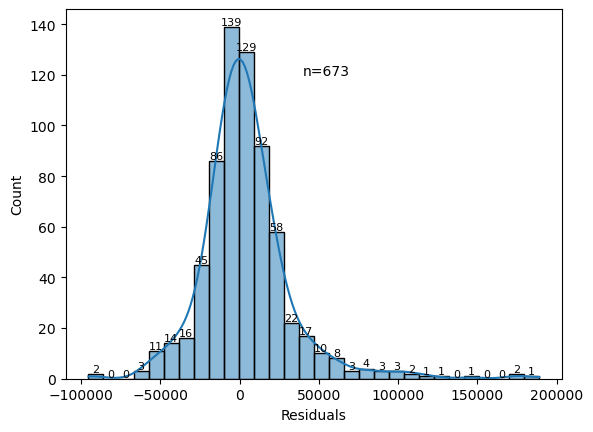

In [15]:
# Residuen zwischen wirklichen und vorhergesagten Verkaufspreisen normalverteilt?
residuals = y_test - y_predtest
y = sns.histplot(residuals, bins=30, stat='count', element="bars", kde=True)
_ = plt.text(40000,120,"n=" + str (df_comparison.shape[0]),color='black')
_ = y.bar_label(y.containers[0], fontsize = 8)
_ = plt.xlabel('Residuals')
plt.show()

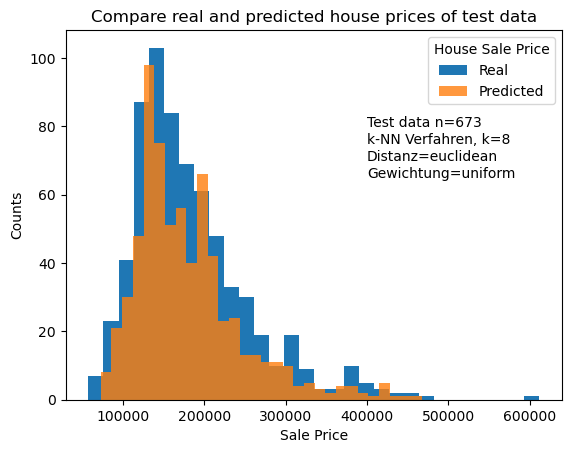

In [16]:
# Vergleich der Verteilungen für wirklichen und vorhergesagten Verkaufspreisen
fig, axes = plt.subplots(1)
plt.rcParams["figure.autolayout"] = True
_ = plt.hist(df_comparison['Actual'],bins=30)
_ = plt.xlabel('Sale Price');
_ = plt.text(400000,80,"Test data n=" + str (df_comparison.shape[0]),color='black')
_ = plt.text(400000,75,"k-NN Verfahren, k=" + str (K_PARAM),color='black')
_ = plt.text(400000,70,"Distanz=" + str (METRIC),color='black')
_ = plt.text(400000,65,"Gewichtung=" + str (WEIGHTS),color='black')
_ = plt.hist(df_comparison['Predicted'],bins=30, alpha=.8)
_ = plt.xlabel('Sale Price');
_ = plt.ylabel('Counts');
_ = plt.title('Compare real and predicted house prices of test data');
_ = plt.legend(title='House Sale Price', loc='upper right', labels=['Real', 'Predicted'])

plt.show()


In [17]:
# Scatterplot für wahre Hauspreise gegen Vorhersagen, mit tool tips

output_notebook(resources=None, verbose=True, hide_banner=True)

df_tip=pd.concat([df_comparison,dfx_test], axis=1, join='inner') 
df_tip['Order'] = dfx_test['Order'].astype('int64')

source = ColumnDataSource(df_tip)

hover = HoverTool(
        tooltips=[
            ("OrderNo", "@Order")
             , ("Sale Price Actual", "@Actual{0}")
             , ("Sale Price Predicted", "@Predicted{0}")
             , ("House Age", "@HouseAge{0}")
             , ("Remodel Age", "@RemodelAge{0}")
             , ("Lot Area", "@{Lot Area}{0}")
             , ("Living Area", "@{Gr Liv Area}{0}")
             , ("Bathrooms", "@TotalBathrooms{0.0}")
             , ("NeighborhoodClass", "@NeighborhoodClass")
        ]
    )

p = figure(width=800, height=400, tools=[hover],
           title="Actual vs predicted Sale Price (see tool tip on house details)", x_range=(0, 700000), 
               y_range=(0, 700000),
           toolbar_location="right", toolbar_sticky=False)
p.add_tools(WheelZoomTool(), BoxZoomTool(), ResetTool())
p.xaxis.axis_label = 'Actual Sale Price'
p.yaxis.axis_label = 'Predicted Sale Price'
p.left[0].formatter.use_scientific = False
p.below[0].formatter.use_scientific = False
_ = p.scatter('Actual', 'Predicted', size=5, source=source)
_ = show(p)

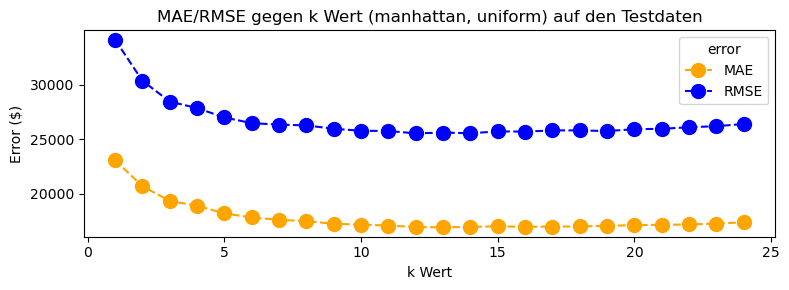

In [19]:
# Optimalen Hyperparameter k für k-Nearest Neighbors bestimmen
METRIC = 'manhattan' # cosine manhattan euclidean Metrik, best gridsearch manhattan
WEIGHTS='uniform' # weights{‘uniform’, ‘distance’} or callable, default=’uniform’, best uniform 

MSE = []
MAE = []
RMSE = []
# Berechne Maßzahlen der Vorhersagequalität für K Werte zwischen 1 and 20
MAXRANGE=25
for N_NEIGHBORS in range(1, MAXRANGE):
    knn = KNeighborsRegressor(n_neighbors=N_NEIGHBORS, weights=WEIGHTS, n_jobs=-1
                              , metric = METRIC)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    MSE.append(met.mean_squared_error(y_test, y_pred))
    MAE.append(met.mean_absolute_error(y_test, y_pred))
    RMSE.append(met.root_mean_squared_error(y_test, y_pred))
    
_ = plt.figure(figsize=(8,3))
_ = plt.plot(range(1, MAXRANGE), MAE, color='orange', linestyle='dashed', marker='o',
         markerfacecolor='orange', markersize=10, label = "MAE")
_ = plt.plot(range(1, MAXRANGE), RMSE, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label = "RMSE")
_ = plt.title('MAE/RMSE gegen k Wert ('+ METRIC + ", " +WEIGHTS+') auf den Testdaten')
_ = plt.xlabel('k Wert')
_ = plt.ylabel('Error ($)')
_ = plt.legend(title='error')

{'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 21], 'weights': ['uniform', 'distance'], 'metric': ['manhattan', 'euclidean', 'cosine']}
Laufzeit GridSearchCV =  22.0  sec
R squared =  0.8696587908737771
Beste Hyperparameter =  {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}


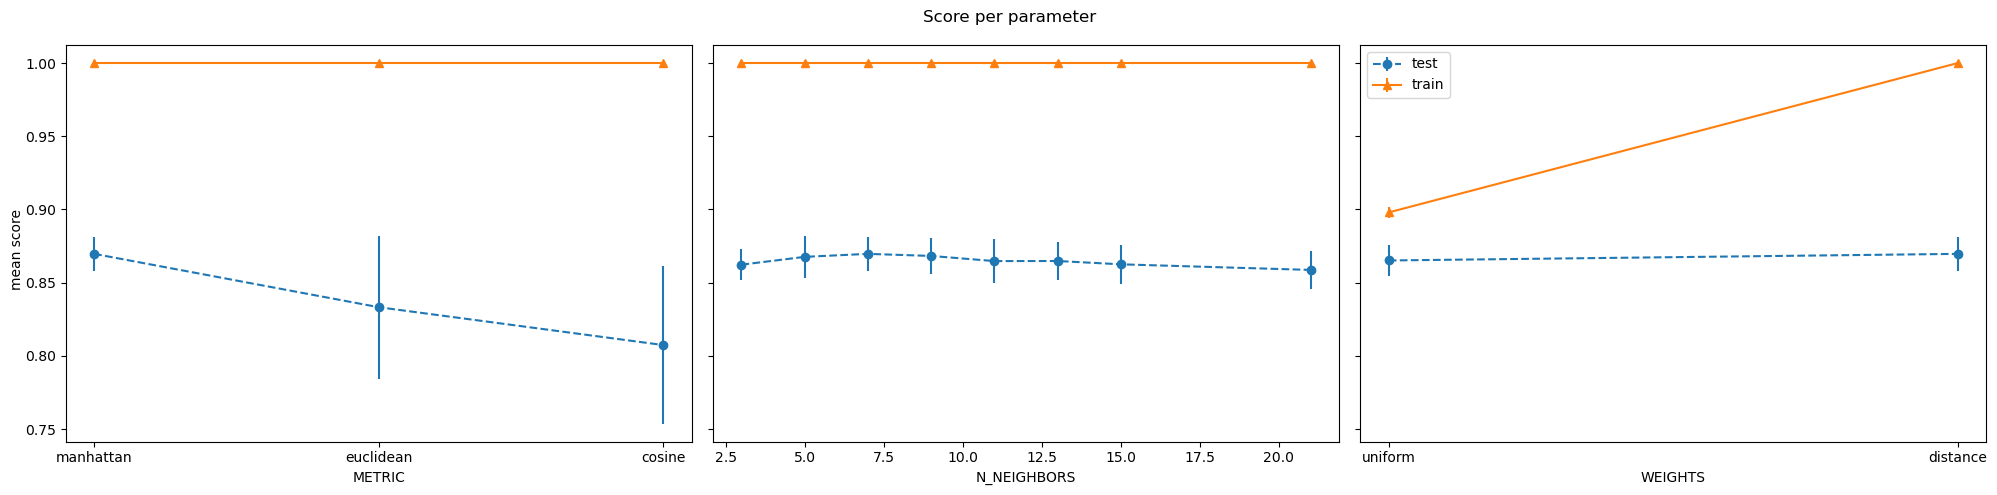

In [20]:
# Automatisches Suchen der besten Hyperparameter mit Sklearn Funktion GridSearchCV


def plot_gridsearch_results_V1 (grid):
    """
    Params: 
        grid: A trained GridSearchCV object. 
    What:
        Plots generically all hyperparameter.
        GridSearchCV needs return_train_score=True.
        score for regression is R2, for classification accuracy(?)
    Source:
        https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv, Jul 12, 2019 
        
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.0, 0.5, 'mean score', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

k_range = [3,5,7,9,11,13,15,21] # list(range(1, 4))
weight_options = ['uniform', 'distance'] #'uniform', 'distance'
metric_options = ['manhattan', 'euclidean', 'cosine' ] #, 'manhattan', 'cosine' euclidean
t0 = timer()
param_grid = dict(n_neighbors=k_range, weights=weight_options, metric=metric_options )
print(param_grid)
grid = GridSearchCV(knn, param_grid, cv=5, return_train_score=True)
grid.fit(x_train, y_train)
t1 = timer()
print ('Laufzeit GridSearchCV = ', round(t1 - t0, 0), ' sec')
print('R squared = ' , grid.best_score_)
print('Beste Hyperparameter = ', grid.best_params_)
#print(pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']])

plot_gridsearch_results_V1(grid)
_='''
saved results
Beste Hyperparameter =  {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'uniform'}

'''